In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def format_p_value(col):
    sig_code_dict = {
        0.001: '***',
        0.01: '**',
        0.05: '*',
        0.1: '.'
    }

    sig_codes = []
    for p in col:
        local_sig_code = ' '
        for sig_level, sig_code in sig_code_dict.items():
            if p < sig_level:
                local_sig_code = sig_code
                break
        sig_codes.append(local_sig_code)

    return sig_codes

In [3]:
def read_coeff(fpath, regressor_name_mapping, max_dist=20):
    coeff_df = pd.read_csv(fpath)
    coeff_df['sig'] = format_p_value(coeff_df['p.value'])

    # Create a complete list of terms and distance groups
    terms = coeff_df['term'].unique()
    terms = [t for t in terms if t != "(Intercept)"]
    phy_quantiles = np.arange(1, max_dist + 1 + 1) # add "all" model
    complete_index = pd.MultiIndex.from_product([phy_quantiles, terms], names=['phy_quantile', 'term'])

    # Create a DataFrame with all possible combinations of phy_quantile and term
    complete_df = pd.DataFrame(index=complete_index).reset_index()

    # Merge the complete DataFrame with the original DataFrame
    coeff_df = pd.merge(complete_df, coeff_df, how='left', on=['phy_quantile', 'term']).fillna(0)

    coeff_df['term'] = coeff_df['term'].map(regressor_name_mapping)

    return coeff_df

In [4]:
class SignedSqrtNorm(mcolors.Normalize):
    """
    Normalization class that applies signed square root transformation
    """
    def __init__(self, vmin=None, vmax=None, clip=False):
        super().__init__(vmin, vmax, clip)
    
    def __call__(self, value, clip=None):
        # Apply signed square root transformation
        def signed_sqrt(x):
            return np.sign(x) * np.sqrt(np.abs(x))
        
        # Transform the data
        if np.isscalar(value):
            transformed_value = signed_sqrt(value)
        else:
            transformed_value = np.array([signed_sqrt(v) for v in value])
        
        # Get the transformed vmin and vmax
        vmin_transformed = signed_sqrt(self.vmin) if self.vmin is not None else None
        vmax_transformed = signed_sqrt(self.vmax) if self.vmax is not None else None
        
        # Apply standard normalization to transformed values
        if vmin_transformed is not None and vmax_transformed is not None:
            normalized = (transformed_value - vmin_transformed) / (vmax_transformed - vmin_transformed)
        else:
            # Fallback to auto-scaling
            if np.isscalar(transformed_value):
                normalized = 0.5  # middle value for single point
            else:
                t_min, t_max = np.min(transformed_value), np.max(transformed_value)
                if t_max == t_min:
                    normalized = np.full_like(transformed_value, 0.5)
                else:
                    normalized = (transformed_value - t_min) / (t_max - t_min)
        
        return np.clip(normalized, 0, 1) if clip else normalized

In [5]:
def plot_heatmap_for_city(area_coeff, regressor_order, fig_name='fig3_c',figsize=(5.5, 2.7), local_max=None):
    max_dist = 20
    p_value_threshold = 0.05
    area_coeff['rank'] = area_coeff['term'].map(regressor_order)

    fig, ax = plt.subplots(1,1, figsize=figsize)
    y_var = 'estimate'
    var_num = len(area_coeff['term'].unique())
    cmap = sns.diverging_palette(230, 10, s=100, l=40, as_cmap=True)
    vmin = area_coeff['estimate'].min()
    vmax = area_coeff['estimate'].max()
    if local_max is None:
        local_max = max(abs(vmin), abs(vmax))
    print(f"local_max: {local_max}")
    marker='s'
    signed_sqrt_norm = SignedSqrtNorm(vmin=-local_max, vmax=local_max)

    scatter_x = area_coeff['phy_quantile'].to_list()
    scatter_y = (var_num + 1 - area_coeff['rank']).to_list()
    scatter_c = area_coeff[y_var].to_list()
    scatter_s = (abs(area_coeff[y_var])*20000) ** (1/2) # for all cities  
    scatter_s = scatter_s.to_list()
    scatter_s = [max(min(x, 80), 0) for x in scatter_s] # putting a cap to size to avoid overlaps
    
    # Create masks for original data points (excluding mean values)
    sig_mask = [p <= p_value_threshold for p in area_coeff['p.value']]
    non_sig_mask = [not sig for sig in sig_mask]
    
    # Plot significant points with fill (normal scatter)
    if any(sig_mask):
        sig_x = [x for x, mask in zip(scatter_x, sig_mask) if mask]
        sig_y = [y for y, mask in zip(scatter_y, sig_mask) if mask]
        sig_c = [c for c, mask in zip(scatter_c, sig_mask) if mask]
        sig_s = [s for s, mask in zip(scatter_s, sig_mask) if mask]
        
        im1 = ax.scatter(sig_x, sig_y, s=sig_s, c=sig_c,
                        cmap=cmap, marker=marker, norm=signed_sqrt_norm)

    # Plot non-significant points with edges only
    if any(non_sig_mask):
        non_sig_x = [x for x, mask in zip(scatter_x, non_sig_mask) if mask]
        non_sig_y = [y for y, mask in zip(scatter_y, non_sig_mask) if mask]
        non_sig_c = [c for c, mask in zip(scatter_c, non_sig_mask) if mask]
        non_sig_s = [s for s, mask in zip(scatter_s, non_sig_mask) if mask]

        non_sig_colors = cmap(signed_sqrt_norm(non_sig_c))
        im2 = ax.scatter(non_sig_x, non_sig_y, s=non_sig_s, c='none', edgecolors=non_sig_colors, 
                        marker=marker, linewidths=1.5)
    im = im1

    # Create an axis on the right side of ax for the color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    # Place the color bar vertically on the right side of the figure
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.yaxis.set_label_position('right')
    cbar.ax.yaxis.set_ticks_position('right')
    cbar.outline.set_visible(False)
    cbar.set_ticks([-0.8, -0.4, -0.1, 0, 0.1, 0.4, 0.8])
    cbar.set_ticklabels(['-0.8', '-0.4', '-0.1', '0', '0.1', '0.4', '0.8'])
    cbar.set_label('Barrier Effect', fontsize=10)
    cbar.ax.minorticks_off()  

    y_labels = list(area_coeff[['term', 'rank']].drop_duplicates().sort_values(by='rank',ascending=False)['term'])
    ax.spines[['right', 'top','left','bottom']].set_visible(False)
    ax.set_yticks(range(1, len(y_labels)+1))
    ax.set_yticklabels(y_labels, fontsize=10)
    ax.set_ylabel('')
    ax.set_ylim(0.5,var_num+0.5)
    ax.set_xticks(range(1, max_dist+1,4))
    ax.set_xlabel('Distance (km)', fontsize=10)

    # set the last tick label to be the 'All'
    xticks = list(ax.get_xticks()) + [max_dist+1]
    ax.set_xticks(xticks)
    xlabels = [f"{t:g}" if t != max_dist+1 else "All" for t in xticks]
    ax.set_xticklabels(xlabels)
    ax.set_xlim(0.5, max_dist+1.5)
    
    ax.tick_params('both', length=0)
    plt.tight_layout()

    plt.savefig(f"../outputs/{fig_name}.pdf", bbox_inches='tight', dpi=300)
    plt.show()
    plt.clf()

    return local_max

## Fig 3c

In [6]:
# Logistic regression variables
demo_vars = [
    'POPULATION_DISTANCE', 
    'RACE_DISTANCE', 
    'HOUSING_PRICE_DISTANCE', 
    'PUBLIC_COMMUTE_DISTANCE'
]
poi_vars = ['Log_POI_INTER_OPP', 'POI_JS_DISTANCE']
phy_vars = [
    "Log_HIGHWAY_NUM", 
    "RAILWAY_NUM", 
    "WATER_NUM", 
    "Log_PARK_NUM"
]

regressor_name_mapping = {
    'RACE_DISTANCE': 'Race Distance',
    'HOUSING_PRICE_DISTANCE': 'SES Distance',
    'PUBLIC_COMMUTE_DISTANCE': 'Public Trans. Distance',
    'Log_POI_INTER_OPP': 'POI Intervening Opp.',
    'POI_JS_DISTANCE': 'POI JS Distance',
    'Log_HIGHWAY_NUM': '# Highways Crossed',
    'Log_PARK_NUM': '# Parks Crossed',
    "Log_RAILWAY_NUM": '# Railways Crossed', 
    "Log_WATER_NUM": '# Waterways Crossed', 
    "diff_county": "Different County"
}

regressor_order = {
    'POI Intervening Opp.': 1,
    'POI JS Distance': 2,
    'Race Distance': 3,
    'SES Distance': 4,
    'Public Trans. Distance': 5,
    '# Waterways Crossed': 6,
    '# Railways Crossed': 7,
    '# Highways Crossed': 8, 
    '# Parks Crossed': 9, 
    'Different County': 10,
}

In [7]:
max_dist = 20
year = 2019
fpath = f"../data/fig3/{year}_fixlogreg_full_coeff_POI_Inter_and_JS.csv"
coeff_df = read_coeff(fpath, regressor_name_mapping, max_dist=20)
figsize=(6,2.5)
fig_name='fig3_c'

local_max: 0.903152249203401


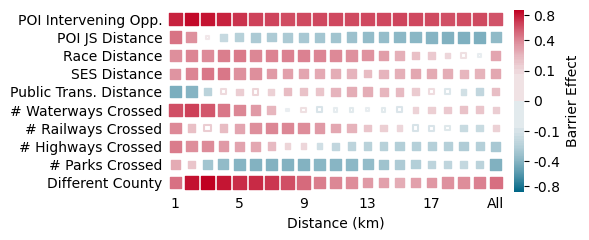

<Figure size 640x480 with 0 Axes>

In [8]:
local_max = plot_heatmap_for_city(coeff_df, regressor_order, fig_name=fig_name, figsize=figsize, local_max=None)

## Fig 3d

In [9]:
regressor_name_mapping = {
    "Log_Transportation": "Transportation",
    "Log_Entertainment": "Entertainment",
    "Log_Shopping": "Shopping",
    "Log_Sports": "Sports",
    "Log_ArtsMuseum": "Arts / Museum",
    "Log_Grocery": "Grocery",
    "Log_Office": "Office",
    "Log_College": "College",
    "Log_Service": "Service"
}

regressor_order = {
    'Shopping': 1,
    'Transportation': 2,
    'College': 3,
    'Arts / Museum': 4,
    'Office': 5,
    'Sports': 6,
    'Entertainment': 7,
    'Grocery': 8,
    'Service': 9
}


In [10]:
max_dist = 20
year = 2019
fpath = f"../data/fig3/{year}_fixlogreg_full_coeff_Cat_POI_Inter.csv"
coeff_df = read_coeff(fpath, regressor_name_mapping, max_dist=20)
coeff_df = coeff_df[coeff_df['term'].isin(list(regressor_name_mapping.values()))]
figsize=(5.5,2.7)
fig_name='fig3_d'

local_max: 0.903152249203401


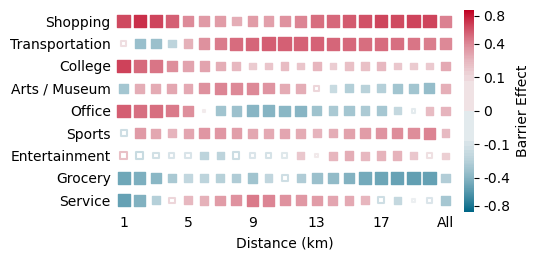

<Figure size 640x480 with 0 Axes>

In [11]:
local_max = plot_heatmap_for_city(coeff_df, regressor_order, fig_name=fig_name, figsize=figsize, local_max=local_max)